In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split

spark = SparkSession \
    .builder \
    .appName("WeatherApp") \
    .getOrCreate()

sc = spark.sparkContext

print("Session démarrée, son id est ", sc.applicationId)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/20 16:58:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Session démarrée, son id est  local-1689872296874


In [3]:
import requests
import os
from datetime import datetime
import csv
from pyspark.sql import *  
from datetime import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import matplotlib.pyplot as plt
# from pyspark.ml.feature import StandardScaler, VectorAssembler
# from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.stat import Correlation
import seaborn as sns
import pandas as pd
from pyspark.ml.linalg import Vectors
from math import sqrt
import pickle
from sklearn.preprocessing import StandardScaler

### Creation du dataset

In [4]:
# def add_to_csv(start_year, start_month, end_year, end_month):
#     print(f"Periode du 20{start_year}-{start_month}-01 au 20{end_year}-{end_month}-01")
#     city="Thies"
#     country="SN"
#     api_key="7262c2a7bc2946609a9b6e25ed24c2e4"
#     base_url = "https://api.weatherbit.io/v2.0/history/subhourly?"
#     start_date=f"20{start_year}-{start_month}-01"
#     end_date=f"20{end_year}-{end_month}-01"
#     url = f"{base_url}city={city}&country={country}&start_date={start_date}&end_date={end_date}&key={api_key}"
#     headers = {"Accept": 'application/json', "Content-Type": 'application/json'}
#     reponse = requests.get(url, headers=headers)
#     try:
#         data = reponse.json()
#         csv_file_path = "Dataset/weather_data.csv"
#         file_exists = os.path.isfile(csv_file_path)
#         headerRow = ['Timestamp','Temperature','Temperature Apparente','Humidite','Pression','Vitesse Vent','Direction Vent','Nuages','Precipitation','Visibilite','Ensoleillement','Description']
#         with open(csv_file_path, 'a', newline='') as csvfile:
#             writer = csv.writer(csvfile)
#             if not file_exists:
#                 writer.writerow(headerRow)
#             for entry in data['data']:
#                 writer.writerow([
#                     datetime.fromisoformat(entry['timestamp_local']),
#                     entry['temp'],
#                     entry['app_temp'],
#                     entry['rh'],
#                     entry['pres'],
#                     entry['wind_spd'],
#                     entry['wind_dir'],
#                     entry['clouds'],
#                     entry['precip_rate'],
#                     entry['vis'],
#                     entry['solar_rad']
#                     entry['weather']['description']
#                 ])
#     except Exception as e:
#         print(reponse)

In [5]:
# months = ['01','02','03','04','05','06','07','08','09','10','11','12']
# years = ['22','23']

# for i in range(len(years)):
#     year = years[i]
#     for j in range(len(months)):  
#         month_start = months[j]
#         if year=="23" and month_start=="07":
#             break
#         if year=="20" and month_start=="12":
#             break
#         if month_start == '12':
#             year_start = year
#             month_end = '01'
#             year_end = years[i+1]
#             add_to_csv(year_start, month_start, year_end, month_end)
#             continue
#         month_end = months[j+1]
#         add_to_csv(year, month_start, year, month_end)

### Pretraitement et Visualisation

In [6]:
inputPath = 'weather_data.csv'

jsonSchema = StructType([
    StructField("Timestamp",TimestampType(),True),
    StructField("Temperature", FloatType(), True),
    StructField("Temperature Apparente", FloatType(), True),
    StructField("Humidite", IntegerType(), True),
    StructField("Pression", IntegerType(), True),
    StructField("Vitesse Vent", FloatType(), True),
    StructField("Direction Vent", FloatType(), True),
    StructField("Nuages", IntegerType(), True),
    StructField("Precipitation", FloatType(), True),
    StructField("Visibilite", IntegerType(), True),
    StructField("Ensoleillement",FloatType(),True),
    StructField("Description", StringType(), True)
])

df = (spark
        .read
        .option("header","true")
        .option("timeStampFormat","yyyy-MM-dd HH:mm:ss")
        .option("delimiter",",")
        .schema(jsonSchema)
        .csv(inputPath))

display(df)

DataFrame[Timestamp: timestamp, Temperature: float, Temperature Apparente: float, Humidite: int, Pression: int, Vitesse Vent: float, Direction Vent: float, Nuages: int, Precipitation: float, Visibilite: int, Ensoleillement: float, Description: string]

In [7]:
rdd = df.rdd.map(lambda row: (row.Timestamp, *row[1:]))
df_with_index = spark.createDataFrame(rdd, ["Timestamp", *df.columns[1:]])
df_with_index.show()

+-------------------+------------------+---------------------+--------+--------+-----------------+--------------+------+-------------+----------+--------------+---------------+
|          Timestamp|       Temperature|Temperature Apparente|Humidite|Pression|     Vitesse Vent|Direction Vent|Nuages|Precipitation|Visibilite|Ensoleillement|    Description|
+-------------------+------------------+---------------------+--------+--------+-----------------+--------------+------+-------------+----------+--------------+---------------+
|2009-01-01 00:00:00|              21.5|   20.899999618530273|      48|    1011|9.199999809265137|          20.0|    90|          0.0|         8|           0.0|Overcast clouds|
|2009-01-01 00:15:00|              21.5|   20.899999618530273|      48|    1011|9.100000381469727|         185.0|    91|          0.0|         9|           0.0|Overcast clouds|
|2009-01-01 00:30:00|              21.5|   20.899999618530273|      48|    1011|              9.0|         350.0|  

In [8]:
null_counts = df.select([col(column).isNull().cast("int").alias(column) for column in df.columns]).\
    agg(*[sum(col(column)).alias(column) for column in df.columns])
null_counts.show()

+---------+-----------+---------------------+--------+--------+------------+--------------+------+-------------+----------+--------------+-----------+
|Timestamp|Temperature|Temperature Apparente|Humidite|Pression|Vitesse Vent|Direction Vent|Nuages|Precipitation|Visibilite|Ensoleillement|Description|
+---------+-----------+---------------------+--------+--------+------------+--------------+------+-------------+----------+--------------+-----------+
|        0|          0|                   24|      24|  262028|           0|            23|     0|            0|         0|             0|          0|
+---------+-----------+---------------------+--------+--------+------------+--------------+------+-------------+----------+--------------+-----------+



In [9]:
filtered_df = df.filter(col("Temperature Apparente").isNull())
filtered_df.show()

+-------------------+-----------+---------------------+--------+--------+------------+--------------+------+-------------+----------+--------------+----------------+
|          Timestamp|Temperature|Temperature Apparente|Humidite|Pression|Vitesse Vent|Direction Vent|Nuages|Precipitation|Visibilite|Ensoleillement|     Description|
+-------------------+-----------+---------------------+--------+--------+------------+--------------+------+-------------+----------+--------------+----------------+
|2023-06-04 00:00:00|       23.9|                 null|    null|    null|         6.6|         310.0|    29|          0.0|        10|           0.0|Scattered clouds|
|2023-06-04 00:15:00|       23.9|                 null|    null|    null|        6.65|         310.0|    29|          0.0|        10|           0.0|Scattered clouds|
|2023-06-04 00:30:00|       23.9|                 null|    null|    null|         6.7|         310.0|    30|          0.0|        10|           0.0|Scattered clouds|
|202

In [10]:
filtered_df = df.filter(col("Pression").isNull())
filtered_df.show()

+-------------------+-----------+---------------------+--------+--------+------------+--------------+------+-------------+----------+--------------+---------------+
|          Timestamp|Temperature|Temperature Apparente|Humidite|Pression|Vitesse Vent|Direction Vent|Nuages|Precipitation|Visibilite|Ensoleillement|    Description|
+-------------------+-----------+---------------------+--------+--------+------------+--------------+------+-------------+----------+--------------+---------------+
|2009-01-07 12:00:00|       25.2|                 24.4|      23|    null|        10.4|          40.0|    92|          0.0|         8|         258.0|Overcast clouds|
|2009-01-07 12:15:00|       25.3|                 24.5|      23|    null|        10.4|          25.0|    92|          0.0|         9|         263.0|Overcast clouds|
|2009-01-07 12:30:00|       25.4|                 24.5|      22|    null|        10.4|          10.0|    92|          0.0|        10|         267.0|Overcast clouds|
|2009-01-0

En visualisant le dataframe nous pouvons voir que les colonnes ou la temperature apparente est absente correspondent egalement a celle pour l'humidite, etant donne leur faible nombre nous allons simplement les supprimer.
Les colonnes nulles pour la pression sont tres nombreuses, conserver cette colonne ne nous sera pas utile pour la prediction de la temperature donc nous allons l'effacer de meme que la colonne description.
Nous allons egalement supprimer les colonnes dupliquees.

In [11]:
df = df.drop("Pression", "Description")
df = df.dropna(subset=["Temperature Apparente", "Direction Vent"])
df = df.dropDuplicates()
df.show()

+-------------------+-----------+---------------------+--------+------------+--------------+------+-------------+----------+--------------+
|          Timestamp|Temperature|Temperature Apparente|Humidite|Vitesse Vent|Direction Vent|Nuages|Precipitation|Visibilite|Ensoleillement|
+-------------------+-----------+---------------------+--------+------------+--------------+------+-------------+----------+--------------+
|2009-01-03 14:45:00|       31.5|                 29.3|      15|         8.1|         305.0|    92|          0.0|         8|         246.0|
|2009-01-07 03:00:00|       17.4|                 17.4|      73|         8.4|          20.0|    92|          0.0|         8|           0.0|
|2009-01-08 07:00:00|       16.3|                 16.3|      60|         9.2|          10.0|    87|          0.0|        10|           0.0|
|2009-01-11 22:30:00|       18.5|                 18.6|      82|         8.6|         360.0|    94|          0.0|        10|           0.0|
|2009-01-13 04:30:00

In [12]:
null_counts = df.select([col(column).isNull().cast("int").alias(column) for column in df.columns]).\
    agg(*[sum(col(column)).alias(column) for column in df.columns])
null_counts.show()

+---------+-----------+---------------------+--------+------------+--------------+------+-------------+----------+--------------+
|Timestamp|Temperature|Temperature Apparente|Humidite|Vitesse Vent|Direction Vent|Nuages|Precipitation|Visibilite|Ensoleillement|
+---------+-----------+---------------------+--------+------------+--------------+------+-------------+----------+--------------+
|        0|          0|                    0|       0|           0|             0|     0|            0|         0|             0|
+---------+-----------+---------------------+--------+------------+--------------+------+-------------+----------+--------------+



In [13]:
df.describe().show()

23/07/20 16:58:25 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+---------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|       Temperature|Temperature Apparente|          Humidite|      Vitesse Vent|    Direction Vent|           Nuages|     Precipitation|        Visibilite|    Ensoleillement|
+-------+------------------+---------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|            510069|               510069|            510069|            510069|            510069|           510069|            510069|            510069|            510069|
|   mean|25.530348037902105|   25.936653661860746| 59.44568087846938| 6.203454997591246|251.39324875654077|51.75453124969367|0.0881579750641756| 9.336725031319292|213.92500426412897|
| stddev| 4.886630038918739|   5.2852092254644205|26.396161588073937|2.24946194691112

In [14]:
def replace_outliers(df, sigma=3):
    """
    This function identifies outliers and replaces them with the column mean.
    """
    df_outliers = df
    for column in df_outliers.columns[1:]:
        if df_outliers.schema[column].dataType != 'string':
            column_mean = df_outliers.select(mean(col(column))).first()[0]
            column_stddev = df_outliers.select(stddev(col(column))).first()[0]
            lower_bound = column_mean - sigma * column_stddev
            upper_bound = column_mean + sigma * column_stddev
            df_outliers = df_outliers.withColumn(
                column,
                when((col(column) < lower_bound) | (col(column) > upper_bound), column_mean).otherwise(col(column))
            )
    
    return df_outliers

df_outliers_replaced = replace_outliers(df)
df_outliers_replaced = df_outliers_replaced.orderBy("Timestamp", ascending=True)

23/07/20 16:58:28 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [15]:
df_outliers_replaced.show()

+-------------------+------------------+---------------------+--------+-----------------+--------------+------+-------------+----------+--------------+
|          Timestamp|       Temperature|Temperature Apparente|Humidite|     Vitesse Vent|Direction Vent|Nuages|Precipitation|Visibilite|Ensoleillement|
+-------------------+------------------+---------------------+--------+-----------------+--------------+------+-------------+----------+--------------+
|2009-01-01 00:00:00|              21.5|   20.899999618530273|    48.0|9.199999809265137|          20.0|  90.0|          0.0|       8.0|           0.0|
|2009-01-01 00:15:00|              21.5|   20.899999618530273|    48.0|9.100000381469727|         185.0|  91.0|          0.0|       9.0|           0.0|
|2009-01-01 00:30:00|              21.5|   20.899999618530273|    48.0|              9.0|         350.0|  92.0|          0.0|      10.0|           0.0|
|2009-01-01 00:45:00|              21.5|   20.899999618530273|    48.0|8.899999618530273

In [16]:
df_outliers_replaced.describe().show()

+-------+------------------+---------------------+-----------------+------------------+------------------+-----------------+-------------------+------------------+------------------+
|summary|       Temperature|Temperature Apparente|         Humidite|      Vitesse Vent|    Direction Vent|           Nuages|      Precipitation|        Visibilite|    Ensoleillement|
+-------+------------------+---------------------+-----------------+------------------+------------------+-----------------+-------------------+------------------+------------------+
|  count|            510069|               510069|           510069|            510069|            510069|           510069|             510069|            510069|            510069|
|   mean|25.521833795965755|    25.93662256146928|59.44568087846938| 6.199254771818379|251.39324875654077|51.75453124969367|0.05467503407452123|  9.45846405185423|213.92500426412897|
| stddev| 4.873315360055564|    5.285162551780448|26.39616158807396| 2.24246126293623

In [17]:
pandas_df = df_outliers_replaced.toPandas()

/opt/homebrew/Cellar/apache-spark/3.4.0/libexec/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


<Axes: xlabel='Timestamp'>

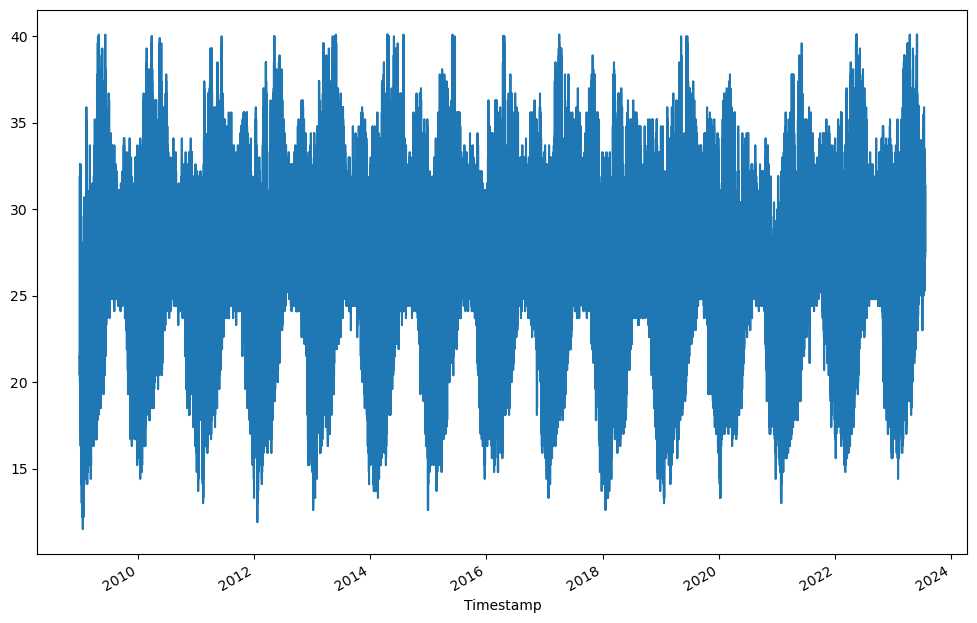

In [18]:
pandas_df = pandas_df.set_index("Timestamp")
pandas_df["Temperature"].plot(figsize=(12,8))

<Axes: xlabel='Timestamp'>

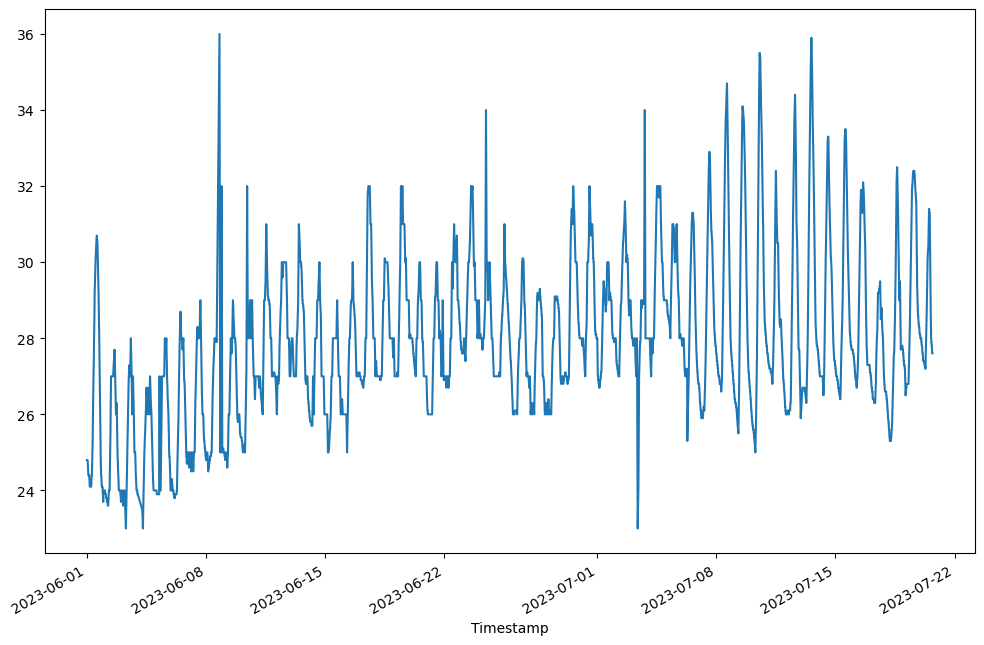

In [19]:
pandas_df["Temperature"]['2023-06-01':].plot(figsize=(12,8))

#### Etudions la correlation entre features et target

In [20]:
y_column = "Temperature"
y = df_outliers_replaced.select(y_column)
X = df_outliers_replaced.drop(y_column)
columns_to_drop = ["Timestamp"]
X = X.drop(*columns_to_drop)

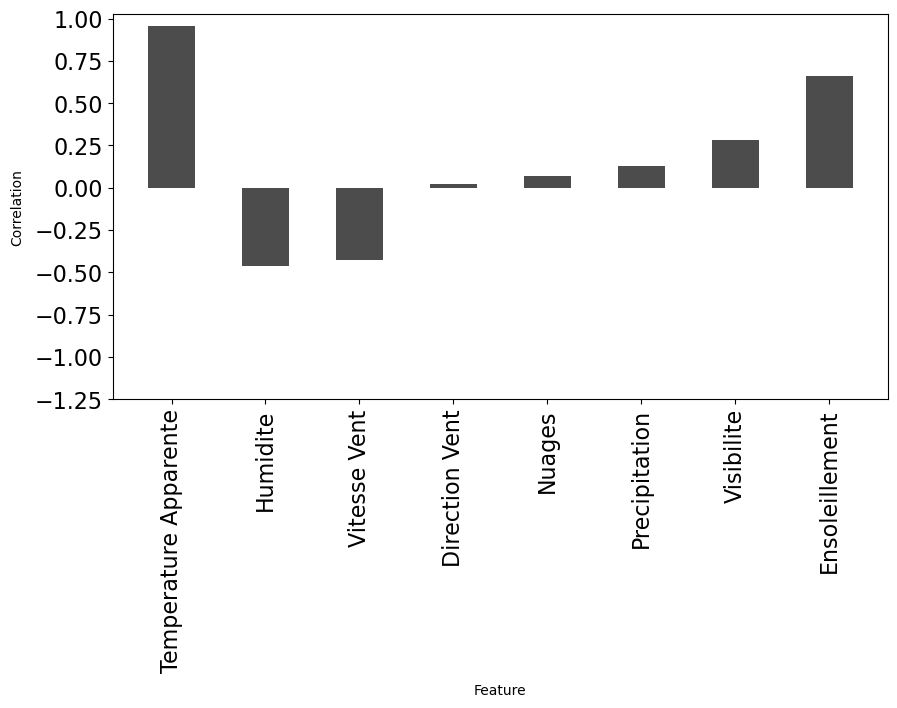

In [21]:
labels = df_outliers_replaced.drop("Timestamp","Temperature").columns

correls = np.zeros(8)
for i in range(8):
    b = np.corrcoef(np.array(X.toPandas())[:,i], np.array(y.toPandas())[:, 0], rowvar=False)
    correls[i] = b[0, 1]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

in_width = 0.5
ar_idxes = np.arange(correls.shape[0])
p1 = ax.bar(ar_idxes, correls, in_width, color='k', edgecolor='none', alpha=0.7)
plt.xticks(ar_idxes, labels, fontsize=16, rotation=90)
plt.yticks(np.arange(-1.25, 1.25, 0.25), fontsize=16)
ax.set_xlabel('Feature', labelpad=8)
ax.set_ylabel("Correlation", labelpad=8)
plt.show()

In [22]:
for st_label, fo_corr in zip(labels, correls):
    print(f"{st_label:20} = {fo_corr:5.2f}")

Temperature Apparente =  0.96
Humidite             = -0.46
Vitesse Vent         = -0.43
Direction Vent       =  0.02
Nuages               =  0.07
Precipitation        =  0.13
Visibilite           =  0.28
Ensoleillement       =  0.66


Nous constatons donc que la direction du vent, la presence de nuage et la precipitation sont faiblement correles a la temperature. Nous allons verifier s'il existe une correlation entre nos features

<Axes: >

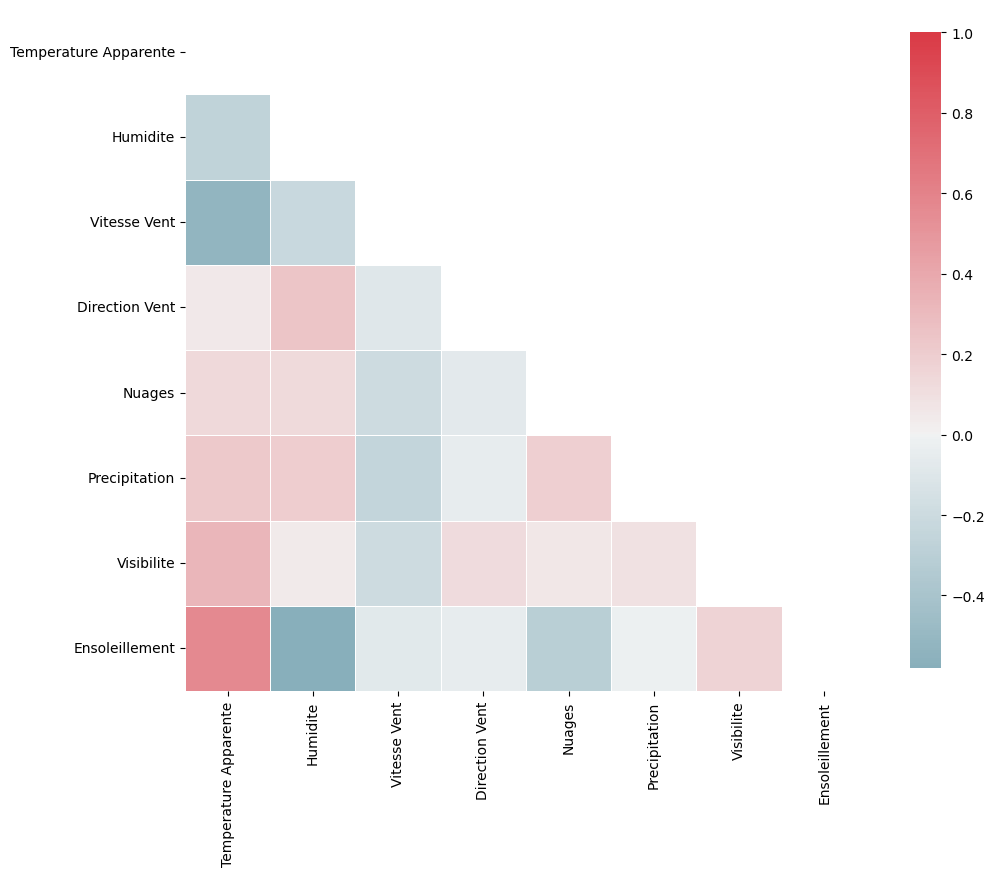

In [23]:
df_norm_data = X.toPandas().copy()

ar_corr_mat = df_norm_data.corr()
ar_mask = np.zeros_like(ar_corr_mat, dtype=bool)
ar_mask[np.triu_indices_from(ar_mask)] = True
f, ax = plt.subplots(figsize=(11, 11))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(ar_corr_mat, mask=ar_mask, cmap=cmap, vmax=1.0, 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .75})

Nous constatons donc que la direction du vente, la presence de nuage, la precipitation et la visibilite n'ont pas de forte correlation avec nos variables

### Creation du jeu de donnees

Pour creer un modele qui peut predire les temperatures moyennes des 3 prochaines heures sur la base des donnees des 15 dernieres minutes, il nous faudra modifier la variable cible temperature afin de donner les temperatures observees sur les 3 heures

In [24]:
y1 = y.toPandas()
df_size = len(df_outliers_replaced.toPandas())
new_y = []

for i in range(len(y1)):
    new_y.append([value[0] for value in y1.values[i:i+12]])
    
new_y = np.array(new_y[:-12])
new_y = new_y.astype(float).tolist()

/opt/homebrew/Cellar/apache-spark/3.4.0/libexec/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [25]:
new_X = X.limit(X.count()-12)
new_X.show()

+---------------------+--------+-----------------+--------------+------+-------------+----------+--------------+
|Temperature Apparente|Humidite|     Vitesse Vent|Direction Vent|Nuages|Precipitation|Visibilite|Ensoleillement|
+---------------------+--------+-----------------+--------------+------+-------------+----------+--------------+
|   20.899999618530273|    48.0|9.199999809265137|          20.0|  90.0|          0.0|       8.0|           0.0|
|   20.899999618530273|    48.0|9.100000381469727|         185.0|  91.0|          0.0|       9.0|           0.0|
|   20.899999618530273|    48.0|              9.0|         350.0|  92.0|          0.0|      10.0|           0.0|
|   20.899999618530273|    48.0|8.899999618530273|         355.0|  92.0|          0.0|      10.0|           0.0|
|   20.899999618530273|    48.0|8.800000190734863|         360.0|  93.0|          0.0|      10.0|           0.0|
|   20.899999618530273|    48.0|8.800000190734863|         360.0|  94.0|          0.0|      10.0

In [26]:
array_schema = ArrayType(FloatType())
target_df = spark.createDataFrame([row for row in new_y], array_schema)
target_df = target_df.withColumnRenamed("value", "Temperature")
target_df.show()

23/07/20 16:59:31 WARN TaskSetManager: Stage 231 contains a task of very large size (5594 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+
|         Temperature|
+--------------------+
|[21.5, 21.5, 21.5...|
|[21.5, 21.5, 21.5...|
|[21.5, 21.5, 21.5...|
|[21.5, 21.5, 21.5...|
|[21.5, 21.5, 21.5...|
|[21.5, 21.5, 21.5...|
|[21.5, 21.5, 21.5...|
|[21.5, 21.5, 21.4...|
|[21.5, 21.4, 21.3...|
|[21.4, 21.3, 21.2...|
|[21.3, 21.2, 21.1...|
|[21.2, 21.1, 21.0...|
|[21.1, 21.0, 20.9...|
|[21.0, 20.9, 20.8...|
|[20.9, 20.8, 20.7...|
|[20.8, 20.7, 20.7...|
|[20.7, 20.7, 20.7...|
|[20.7, 20.7, 20.7...|
|[20.7, 20.7, 20.7...|
|[20.7, 20.7, 20.7...|
+--------------------+
only showing top 20 rows



23/07/20 16:59:35 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 231 (TID 772): Attempting to kill Python Worker


In [27]:
w = Window.orderBy(monotonically_increasing_id())

new_X=  new_X.withColumn("index", row_number().over(w))
new_y=  target_df.withColumn("index_y", row_number().over(w))

final_df = new_X.join(new_y, new_X.index == new_y.index_y, 'inner').drop("index_y").drop("index")

final_df.count()

23/07/20 16:59:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/20 16:59:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/20 16:59:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/20 16:59:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/20 16:59:35 WARN TaskSetManager: Stage 233 contains a task of very large size (5594 KiB). The maximum recommended task size is 1000 KiB.
23/07/20 16:59:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/20 16:59:35 WARN WindowExe

510057

In [28]:
final_df.show()

23/07/20 16:59:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/20 16:59:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/20 16:59:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/20 16:59:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/20 16:59:36 WARN TaskSetManager: Stage 240 contains a task of very large size (5594 KiB). The maximum recommended task size is 1000 KiB.
23/07/20 16:59:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/20 16:59:37 WARN WindowExe

+---------------------+--------+-----------------+--------------+------+-------------+----------+--------------+--------------------+
|Temperature Apparente|Humidite|     Vitesse Vent|Direction Vent|Nuages|Precipitation|Visibilite|Ensoleillement|         Temperature|
+---------------------+--------+-----------------+--------------+------+-------------+----------+--------------+--------------------+
|   19.899999618530273|    42.0|              8.0|          15.0|  95.0|          0.0|       8.0|           0.0|[20.6, 20.6, 20.5...|
|   19.799999237060547|    42.0|              8.0|          10.0|  94.0|          0.0|       8.0|           0.0|[20.6, 20.5, 20.4...|
|   19.700000762939453|    42.0|              8.0|         185.0|  94.0|          0.0|       8.0|           0.0|[20.5, 20.4, 20.6...|
|   19.899999618530273|    40.0|7.800000190734863|         360.0|  94.0|          0.0|       8.0|          23.0|[20.7, 20.9, 21.1...|
|                 20.5|    36.0|7.400000095367432|         355

In [29]:
# assembler = VectorAssembler(inputCols=final_df.columns[:-1], outputCol="features")
# vectorized_data = assembler.transform(final_df)
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
# scaler_model = scaler.fit(vectorized_data)
# scaled_data = scaler_model.transform(vectorized_data)
# scaled_data.select("scaledFeatures").show()

In [30]:
X = final_df.drop("Temperature").toPandas()
y = final_df.select("Temperature").toPandas()
scaler_model = StandardScaler()
X = scaler_model.fit_transform(X)

23/07/20 16:59:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/20 16:59:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/20 16:59:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/20 16:59:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/20 16:59:38 WARN TaskSetManager: Stage 253 contains a task of very large size (5594 KiB). The maximum recommended task size is 1000 KiB.
23/07/20 16:59:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/07/20 16:59:38 WARN WindowExe

In [31]:
data = list(zip(X.tolist(),y["Temperature"].tolist()))
final_df = spark.createDataFrame(data,["scaledFeatures","Temperature"])

final_df.count()

23/07/20 17:00:04 WARN TaskSetManager: Stage 266 contains a task of very large size (9319 KiB). The maximum recommended task size is 1000 KiB.


510057

In [32]:
df_size = final_df.count()
rows = final_df.collect()
train_rows = rows[:int(df_size*0.9)] 
test_rows = rows[int(df_size*0.9):]

23/07/20 17:00:09 WARN TaskSetManager: Stage 269 contains a task of very large size (9319 KiB). The maximum recommended task size is 1000 KiB.
23/07/20 17:00:09 WARN TaskSetManager: Stage 272 contains a task of very large size (9319 KiB). The maximum recommended task size is 1000 KiB.


In [33]:
trainData = spark.createDataFrame(train_rows)
testData = spark.createDataFrame(test_rows)

In [35]:
X_train, y_train = np.array(trainData.toPandas()['scaledFeatures'].tolist()), np.array(trainData.toPandas()['Temperature'].tolist())
X_test, y_test = np.array(testData.toPandas()['scaledFeatures'].tolist()), np.array(testData.toPandas()['Temperature'].tolist())
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

23/07/20 17:02:12 WARN TaskSetManager: Stage 274 contains a task of very large size (8369 KiB). The maximum recommended task size is 1000 KiB.
23/07/20 17:02:30 WARN TaskSetManager: Stage 275 contains a task of very large size (8369 KiB). The maximum recommended task size is 1000 KiB.


### Entrainement du modele

In [36]:
from keras.models import Sequential
from keras.layers import LSTM,Dense ,Dropout, Bidirectional

regressor = Sequential()
regressor.add(Bidirectional(LSTM(units=96, return_sequences=True, input_shape = (X_train.shape[1],1) ) ))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 96, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 48, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 24))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 12,activation='linear'))
regressor.compile(optimizer='adam', loss='mean_absolute_error')

Metal device set to: Apple M2 Pro


In [38]:
regressor.fit(X_train, y_train, epochs=10,batch_size=32)

Epoch 1/10
14346/14346 [==============================] - 329s 23ms/step - loss: 0.6382
Epoch 2/10
14346/14346 [==============================] - 327s 23ms/step - loss: 0.6272
Epoch 3/10
14346/14346 [==============================] - 326s 23ms/step - loss: 0.6195
Epoch 4/10
14346/14346 [==============================] - 328s 23ms/step - loss: 0.6132
Epoch 5/10
14346/14346 [==============================] - 328s 23ms/step - loss: 0.6090
Epoch 6/10
14346/14346 [==============================] - 329s 23ms/step - loss: 0.6044
Epoch 7/10
14346/14346 [==============================] - 331s 23ms/step - loss: 0.6003
Epoch 8/10
14346/14346 [==============================] - 340s 24ms/step - loss: 0.5979
Epoch 9/10
14346/14346 [==============================] - 337s 23ms/step - loss: 0.5948
Epoch 10/10
14346/14346 [==============================] - 338s 24ms/step - loss: 0.5934


In [39]:
regressor.evaluate(X_test, y_test)

1594/1594 [==============================] - 15s 9ms/step - loss: 0.7409


0.7409260869026184

In [40]:
predictions = regressor.predict(X_test)
predictions

1594/1594 [==============================] - 13s 8ms/step


array([[21.257593, 21.056276, 20.866995, ..., 19.62882 , 19.494823,
        19.37184 ],
       [21.044329, 20.854366, 20.6767  , ..., 19.51446 , 19.388462,
        19.272928],
       [20.86579 , 20.683994, 20.514835, ..., 19.41315 , 19.294163,
        19.185266],
       ...,
       [30.967243, 31.011648, 31.060526, ..., 30.663376, 30.528383,
        30.372068],
       [30.433735, 30.468084, 30.508718, ..., 30.126402, 30.002981,
        29.860758],
       [29.583916, 29.511896, 29.448841, ..., 28.582054, 28.432661,
        28.275034]], dtype=float32)

In [41]:
def compute_errors(actual, predictions):
    maes=[]
    rmses=[]
    for (a, s) in zip(actual, predictions):
        maes.append(float(np.mean(np.abs(a - s))))
        rmses.append(float(np.sqrt(np.mean((a - s)**2))))
    return (maes, rmses)

maes,rmses=compute_errors(y_test,predictions)

In [42]:
data = list(zip(predictions.tolist(),y_test.tolist(),maes,rmses))
res = spark.createDataFrame(data,["Predictions","Actual","MAE","RMSE"])

res.show()

+--------------------+--------------------+-------------------+-------------------+
|         Predictions|              Actual|                MAE|               RMSE|
+--------------------+--------------------+-------------------+-------------------+
|[21.2575931549072...|[21.5, 21.2999992...|0.32866700490315753|0.34339899933003226|
|[21.0443286895751...|[21.2999992370605...|  0.322353998819987| 0.3342031106804016|
|[20.8657894134521...|[21.1000003814697...|0.29544655481974286| 0.3071282361653911|
|[20.6875934600830...|[20.8999996185302...| 0.2895350456237793|0.30050877444007795|
|[20.5108203887939...|[20.7000007629394...| 0.2859775225321452|0.29806010717251963|
|[20.3343181610107...|[20.6000003814697...| 0.2850855191548665| 0.3016288618667091|
|[20.1556415557861...|[20.3999996185302...|0.28224849700927734| 0.3084375302374744|
|[20.0688362121582...|[20.2999992370605...|0.22580703099568686| 0.2486417175161051|
|[19.9812889099121...|[20.2000007629394...| 0.1937088966369629| 0.2141094685

23/07/20 18:18:32 WARN TaskSetManager: Stage 278 contains a task of very large size (1232 KiB). The maximum recommended task size is 1000 KiB.


In [43]:
res.describe().show()

23/07/20 18:18:32 WARN TaskSetManager: Stage 279 contains a task of very large size (1232 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+-------------------+
|summary|                 MAE|               RMSE|
+-------+--------------------+-------------------+
|  count|               51006|              51006|
|   mean|  0.7409261897712494| 0.8600924437269417|
| stddev|  0.9572772570333892| 1.1317836610645144|
|    min|0.015961170196533203|0.02193832651038905|
|    max|  15.134921709696451| 15.156997845510947|
+-------+--------------------+-------------------+



In [44]:
regressor.save("../API/src/models/model.h5")
with open("../API/src/models/scaler.pkl","wb") as file:
    pickle.dump(scaler_model, file)